# Walking Tour Results
This notebook is part of a project investigating the potential of reinforcement learning in a travel itinerary planning application. 

The notebook analyses data that has been generated by running a simplified RL algorithm called walking tour for an example case. For more information on or the code for the walking tour algorithm view the project report  or the notebook Walking Tour Functions both located in this Github repository.   

This example takes a user visiting Austin, Texas, staying at the Wyndham hotel and interested in the category Art Gallery, Historic Site, Asian Restaurant, Dessert Shop and Trail. Our user is willing to travel 300 meters between stops and wants to visit 4 places before returning to the hotel.The input for this case can be found in the table below.

|Variable|Value|
|---|---|
|address|'516 W 8th Street Austin TX'|
|categories|['4bf58dd8d48988d1e2931735', '4deefb944765f83613cdba6e','4bf58dd8d48988d142941735', '4bf58dd8d48988d1d0941735', '4bf58dd8d48988d159941735']|
|D|300|
|N|4|


### Table of Contents
#### 1. Problem Environment
#### 2. All Solutions
#### 3. N_steps=1500 Analysis
#### 4. N_steps=5000 Analysis
#### 5. 99th Percentile Analysis
#### 6. 95th Percentile Analysis

##### Load & Install Packages

In [1]:
#Install, import and load dependencies
import numpy as np # library to handle data in a vectorized manner

import random
import copy

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


!conda install -c conda-forge folium=0.6.0 --yes # uncomment this line if you haven't installed folium
import folium # map rendering library
from folium import features, FeatureGroup, LayerControl, plugins

import datetime

%matplotlib inline
import seaborn as sns

import scipy
from scipy import interpolate

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.5           |   py36h1ba5d50_0         643 KB
    conda-4.6.3                |           py36_0         872 KB  conda-forge
    openssl-1.1.1a             |    h14c3975_1000         4.0 MB  conda-forge
    libarchive-3.3.3           |       h5d8350f_5         1.5 MB
    grpcio-1.16.1              |   py36hf8bcb03_1         1.1 MB
    folium-0.6.0               |             py_0          51 KB  conda-forge
    libssh2-1.8.0              |                1         239 KB  conda-forge
    python-3.6.8               |       h0371630_0        34.4 MB
    ------------------------------------------------------------
                                           Total:        42.7 MB

The followi

Define functions used for analysis

In [2]:
def getlines(Loop, D, N, vens, starts):
    start = starts
    venues = vens
    loop = Loop.drop('Value', axis=1)
    lines = pd.DataFrame(columns=['begin', 'end', 'loop'])
    r = 0
    l = 0
    while r <= len(Loop)-1:
        while l <= ((len(Loop)-1)*(N+1)):
            for c in range(N+1):
                lines.loc[l] = ''
                if c == 0:
                    venue_index = venues.index[venues['name'] == loop.iloc[r,c]][0]
                    lines.iloc[l, 0] = [start[0], start[1]]
                    lines.iloc[l, 1] = [venues.iloc[venue_index, 1][0], venues.iloc[venue_index, 1][1]]
                elif c == N:
                    lines.iloc[l, 0] = [venues.iloc[venue_index, 1][0], venues.iloc[venue_index, 1][1]]
                    lines.iloc[l, 1] = [start[0], start[1]]

                else:
                    venue_index = venues.index[venues['name'] == loop.iloc[r,c]][0]
                    lines.iloc[l, 0] = lines.iloc[l-1, 1]
                    lines.iloc[l, 1] = [venues.iloc[venue_index, 1][0], venues.iloc[venue_index, 1][1]]
                lines.iloc[l, 2] = r
                l += 1
            r += 1
    return lines
def percentile_optimal(x):
    return scipy.stats.percentileofscore(OLoop['Value'], x)
def score_optimal(x):
    return scipy.stats.scoreatpercentile(OLoop['Value'], x)

#### 1. Problem Environment

Load Data

In [3]:
address = '516 W 8th Street Austin TX'
start = [30.2713320408163, -97.7469014285714]
categories = ['4bf58dd8d48988d1e2931735',
        '4deefb944765f83613cdba6e',
        '4bf58dd8d48988d142941735',
        '4bf58dd8d48988d1d0941735',
        '4bf58dd8d48988d159941735']
venues = pd.read_csv('venuesE1.csv', index_col=0)
for r in range(len(venues)):
    venues['location'][r] = eval(venues['location'][r])
D = 300
N = 4
OLoop = pd.read_csv('OLoopE1.csv', index_col=0)
#%store -r BL
BL = 103 #use this line if BL has not been stored. This is only good for E1

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#Summary of venues in primary category and sub-category
cID_summary = pd.DataFrame(columns = ['count', 'mean distance from start'])
cID_summary['count'] = venues.groupby('category ID').count()['name']
cID_summary['mean distance from start'] = venues.groupby('category ID').mean()['distance from start']

cat_summary = pd.DataFrame(columns = ['count', 'mean distance from start'])
cat_summary['count'] = venues.groupby(['category ID', 'category']).count()['name']
cat_summary['mean distance from start'] = venues.groupby(['category ID', 'category']).mean()['distance from start']

print(cID_summary)
print()
print(cat_summary)


                          count  mean distance from start
category ID                                              
4bf58dd8d48988d142941735     11                479.909091
4bf58dd8d48988d1d0941735      3                526.666667
4bf58dd8d48988d1e2931735     20                457.450000
4deefb944765f83613cdba6e      3                182.333333

                                                    count  \
category ID              category                           
4bf58dd8d48988d142941735 Asian Restaurant               2   
                         Chinese Restaurant             2   
                         Food Truck                     2   
                         Japanese Curry Restaurant      1   
                         Japanese Restaurant            1   
                         Sushi Restaurant               2   
                         Thai Restaurant                1   
4bf58dd8d48988d1d0941735 Dessert Shop                   1   
                         Food Truck      

In [8]:
#Create a map with the starting location and all possible venues
# create map
map_env = folium.Map(location=start, zoom_start=15)

rainbow = ['red', 'orange', 'green', 'blue', 'purple']

# add markers to the map
folium.Marker(start).add_to(map_env)
folium.Circle(start, radius=D).add_to(map_env)

for loc, cat, catid, name in zip(venues['location'], venues['category'], venues['category ID'], venues['name']):
    label = folium.Popup(str(name)+': '+str(cat), parse_html=True)
    folium.CircleMarker(loc, radius=3, popup=label, color=rainbow[categories.index(catid)], 
                        fill=True, fill_color=rainbow[categories.index(catid)], fill_opacity=0.7).add_to(map_env)



map_env


#### 2. All Solutions

In [9]:
OLoop.describe()

,Value
count,1990.000000
mean,54.159656
std,9.146873
min,33.158192
25%,48.572919
50%,55.997579
75%,61.059308
max,72.787446


In [10]:
pBL = BL/(len(OLoop)+BL)*100
print('The percent of Bad Loops for all possible loops is %.2f%%' % pBL)

The percent of Bad Loops for all possible loops is 4.92%


Create map displaying venues and top solutions

In [16]:
#Create a map with the starting location and top two venues
# create map
map_top = folium.Map(location=start, zoom_start=16)

rainbow = ['red', 'orange', 'green', 'blue', 'purple']

# add markers to the map
text = 'Test'
startgroup = FeatureGroup(name='Start')
folium.Marker(start).add_to(startgroup)
folium.Circle(start, radius=D).add_to(startgroup)
startgroup.add_to(map_top)



# add lines to the map
Loop = OLoop.reset_index(drop=True)
lines = getlines(OLoop.iloc[0:5], D, N, venues, start)
#lines = getlines(OLoop.iloc[len(OLoop)-5:len(OLoop)], D, N, venues, start)
color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
for l in range(2):
    name = 'Solution ' + str(l+1)
    namegroup = FeatureGroup(name=name, show=False)
    points = ['']*2*(N+1) 
    points[0:(N+1)] = lines.iloc[l*(N+1):l*(N+1)+(N+2), 0]
    points[N+1] = points[0]
    icon_anchor = [(0,0), (0,0), (0,-5), (100,0), (100,0), (0,0), (0,0), (0,0)]
    for i in range(1, N+1):
        point = points[i]
        stop = 'Stop ' + str(i) +': '
        text = OLoop.iloc[l, i]
        folium.Marker(point, icon=features.DivIcon(icon_size=(100, 30), icon_anchor=icon_anchor[(i-1)+(l*3)],
        html='<div style="font-size: 10pt"><p style="background-color:#ffffff;"><b>%s</b>%s</p></div>' % (stop, text))).add_to(namegroup)
    features.ColorLine(points, colors=[1, 1, 1, 1, 1], colormap=[color[l], color[l]], weight=3).add_to(namegroup)
    namegroup.add_to(map_top)

venuegroup = FeatureGroup(name='Venues')
for loc, cat, catid, name in zip(venues['location'], venues['category'], venues['category ID'], venues['name']):
    label = folium.Popup(str(name)+': '+str(cat), parse_html=True)
    folium.CircleMarker(loc, radius=3, popup=label, color=rainbow[categories.index(catid)], 
                        fill=True, fill_color=rainbow[categories.index(catid)], fill_opacity=0.7).add_to(venuegroup)
venuegroup.add_to(map_top)

LayerControl().add_to(map_top)

map_top


In [24]:
#Create a map with selectable layers for solutions in the 99th percentile of results from optimalloops function
# create map
map_top = folium.Map(location=start, zoom_start=16)

rainbow = ['red', 'orange', 'green', 'blue', 'purple']

# add markers to the map
text = 'Test'
startgroup = FeatureGroup(name='Start')
folium.Marker(start).add_to(startgroup)
folium.Circle(start, radius=D).add_to(startgroup)
startgroup.add_to(map_top)

venuegroup = FeatureGroup(name='Venues')
for loc, cat, catid, name in zip(venues['location'], venues['category'], venues['category ID'], venues['name']):
    label = folium.Popup(str(name)+': '+str(cat), parse_html=True)
    folium.CircleMarker(loc, radius=3, popup=label, color=rainbow[categories.index(catid)], 
                        fill=True, fill_color=rainbow[categories.index(catid)], fill_opacity=0.7).add_to(venuegroup)
venuegroup.add_to(map_top)

legend = 'Walking Tour/Venue_Category_Legend.png'
O99 = score_optimal(99)
OLoop99 = OLoop[OLoop['Value'] >= O99]
# add lines to the map
Loop = OLoop99.reset_index(drop=True)
lines = getlines(OLoop99, D, N, venues, start)
#lines = getlines(OLoop.iloc[len(OLoop)-5:len(OLoop)], D, N, venues, start)
for l in range(len(OLoop99)):
    name = 'Solution ' + str(l+1)
    namegroup = FeatureGroup(name=name)
    points = ['']*(N+2) 
    points[0:(N+1)] = lines.iloc[l*(N+1):l*(N+1)+(N+2), 0]
    points[N+1] = points[0]


    features.ColorLine(points, colors=[1, 1, 1, 1, 1], weight=3).add_to(namegroup)
    namegroup.add_to(map_top)
LayerControl().add_to(map_top)

map_top


Map of solutions in the 95th to 96th percentile

In [25]:
#Create a map with the starting location and all possible venues
# create map
map_p95 = folium.Map(location=start, zoom_start=15)

rainbow = ['red', 'orange', 'green', 'blue', 'purple']

# add markers to the map
startgroup = FeatureGroup(name='Start')
folium.Marker(start).add_to(startgroup)
folium.Circle(start, radius=D).add_to(startgroup)
startgroup.add_to(map_p95)

venuegroup = FeatureGroup(name='Venues')
for loc, cat, catid, name in zip(venues['location'], venues['category'], venues['category ID'], venues['name']):
    label = folium.Popup(str(name)+': '+str(cat), parse_html=True)
    folium.CircleMarker(loc, radius=3, popup=label, color=rainbow[categories.index(catid)], 
                        fill=True, fill_color=rainbow[categories.index(catid)], fill_opacity=0.7).add_to(venuegroup)
venuegroup.add_to(map_p95)

# add lines to the map
O95 = score_optimal(95)
O96 = score_optimal(96)
OLoop95 = OLoop[OLoop['Value'] >= O95]
OLoop95 = OLoop95[OLoop95 < O96]
Loop = OLoop95.reset_index(drop=True)
lines = getlines(OLoop95, D, N, venues, start)
for l in range(len(OLoop95)):
    name = 'Solution ' + str(l+1)
    namegroup = FeatureGroup(name=name)
    points = ['']*2*(N+1)
    color = [1, 1, 1, 1, 1]
    points[0:(N+1)] = lines.iloc[l*(N+1):l*(N+1)+(N+2), 0]
    points[N+1] = points[0]
    features.ColorLine(points, color, weight=3).add_to(namegroup)
    namegroup.add_to(map_p95)

LayerControl().add_to(map_p95)

map_p95


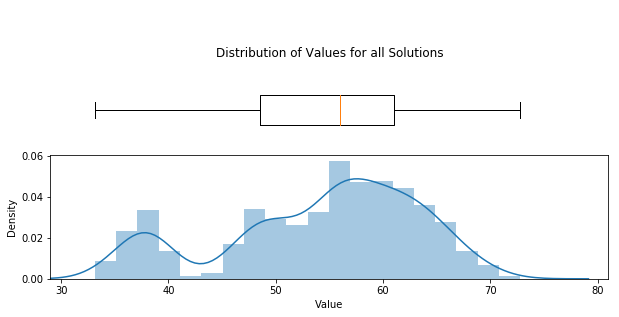

In [26]:
x = OLoop['Value']

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(2, 1, 2)
sns.distplot(x, ax=ax1)
ax1.set_xlabel('Value')
ax1.set_xlim(29, 81)
ax1.set_ylabel('Density')


ax2 = fig.add_subplot(2, 1, 1)
ax2.boxplot(x, vert=False)
ax2.set_title('Distribution of Values for all Solutions', pad=-50)
ax2.axis('off')
ax2.set_xlim(29, 81)
ax2.set_ylim(.9, 1.5)

plt.show()

#### 3. N_steps=1500 Analysis

Load Data

In [27]:
epsilon_ = 0.1
gamma_ = 1
its = 5
N_steps = 1500

filepre = 'E1Loop' + str(N_steps)+ 'e' + str(int(epsilon_*100)) + 'g' + str(int(gamma_*100))
detfilepre = 'E1Loop_det' + str(N_steps)+ 'e' + str(int(epsilon_*100)) + 'g' + str(int(gamma_*100))
vfile = 'E1vars' + str(N_steps)+ 'e' + str(int(epsilon_*100)) + 'g' + str(int(gamma_*100)) + '.csv'
filename = ['']*its
detfilename = ['']*its
for i in range(1, its+1):
    filesuff = '_' + str(i) + '.csv'
    file = filepre + filesuff
    detfile = detfilepre + filesuff
    filename[i-1] = file
    detfilename[i-1] = detfile
E1vars1500 = pd.read_csv(vfile, index_col=0)
E1Loop1500_1 = pd.read_csv(filename[0], index_col=0)
E1Loop1500_2 = pd.read_csv(filename[1], index_col=0)
E1Loop1500_3 = pd.read_csv(filename[2], index_col=0)
E1Loop1500_4 = pd.read_csv(filename[3], index_col=0)
E1Loop1500_5 = pd.read_csv(filename[4], index_col=0)
E1vars1500.describe()

,L,BL
count,5.00000,5.00000
mean,294.20000,6.60000
std,1.30384,1.67332
min,293.00000,4.00000
25%,293.00000,6.00000
50%,294.00000,7.00000
75%,295.00000,8.00000
max,296.00000,8.00000


Separate loops and bad loops

In [28]:
BLE1Loop1500_1 = pd.DataFrame(columns=E1Loop1500_1.columns)
LE1Loop1500_1 = pd.DataFrame(columns=E1Loop1500_1.columns)
for r in range(len(E1Loop1500_1)):
    if E1Loop1500_1.iloc[r, 1] == 0:
        BLE1Loop1500_1 = BLE1Loop1500_1.append(E1Loop1500_1.loc[r])
    else:
        LE1Loop1500_1 = LE1Loop1500_1.append(E1Loop1500_1.loc[r])

BLE1Loop1500_2 = pd.DataFrame(columns=E1Loop1500_2.columns)
LE1Loop1500_2 = pd.DataFrame(columns=E1Loop1500_2.columns)
for r in range(len(E1Loop1500_2)):
    if E1Loop1500_2.iloc[r, 1] == 0:
        BLE1Loop1500_2 = BLE1Loop1500_2.append(E1Loop1500_2.loc[r])
    else:
        LE1Loop1500_2 = LE1Loop1500_2.append(E1Loop1500_2.loc[r])
        
BLE1Loop1500_3 = pd.DataFrame(columns=E1Loop1500_3.columns)
LE1Loop1500_3 = pd.DataFrame(columns=E1Loop1500_3.columns)
for r in range(len(E1Loop1500_3)):
    if E1Loop1500_3.iloc[r, 1] == 0:
        BLE1Loop1500_3 = BLE1Loop1500_3.append(E1Loop1500_3.loc[r])
    else:
        LE1Loop1500_3 = LE1Loop1500_3.append(E1Loop1500_3.loc[r])
        
BLE1Loop1500_4 = pd.DataFrame(columns=E1Loop1500_4.columns)
LE1Loop1500_4 = pd.DataFrame(columns=E1Loop1500_4.columns)
for r in range(len(E1Loop1500_4)):
    if E1Loop1500_4.iloc[r, 1] == 0:
        BLE1Loop1500_4 = BLE1Loop1500_4.append(E1Loop1500_4.loc[r])
    else:
        LE1Loop1500_4 = LE1Loop1500_4.append(E1Loop1500_4.loc[r])
        
BLE1Loop1500_5 = pd.DataFrame(columns=E1Loop1500_5.columns)
LE1Loop1500_5 = pd.DataFrame(columns=E1Loop1500_5.columns)
for r in range(len(E1Loop1500_5)):
    if E1Loop1500_5.iloc[r, 1] == 0:
        BLE1Loop1500_5 = BLE1Loop1500_5.append(E1Loop1500_5.loc[r])
    else:
        LE1Loop1500_5 = LE1Loop1500_5.append(E1Loop1500_5.loc[r])
        

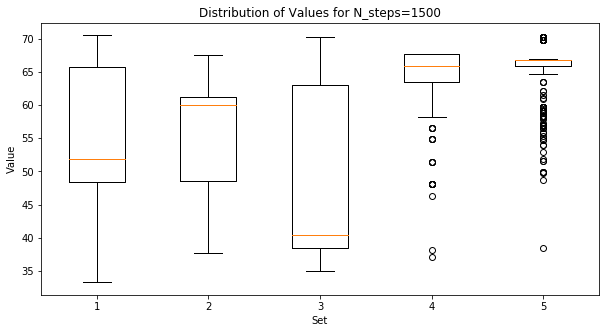

In [29]:
x1 = LE1Loop1500_1['Value']
x2 = LE1Loop1500_2['Value']
x3 = LE1Loop1500_3['Value']
x4 = LE1Loop1500_4['Value']
x5 = LE1Loop1500_5['Value']

fig0 = plt.figure(figsize=(10,5))
ax1 = fig0.add_subplot(1, 1, 1)
ax1.boxplot([x1, x2, x3, x4, x5])

ax1.set_xlabel('Set')
ax1.set_ylabel('Value')
ax1.set_title('Distribution of Values for N_steps=1500')
fig0.savefig('Distribution of Values for N_steps=1500')
plt.show()

Look at Occurrences of Bad Loops

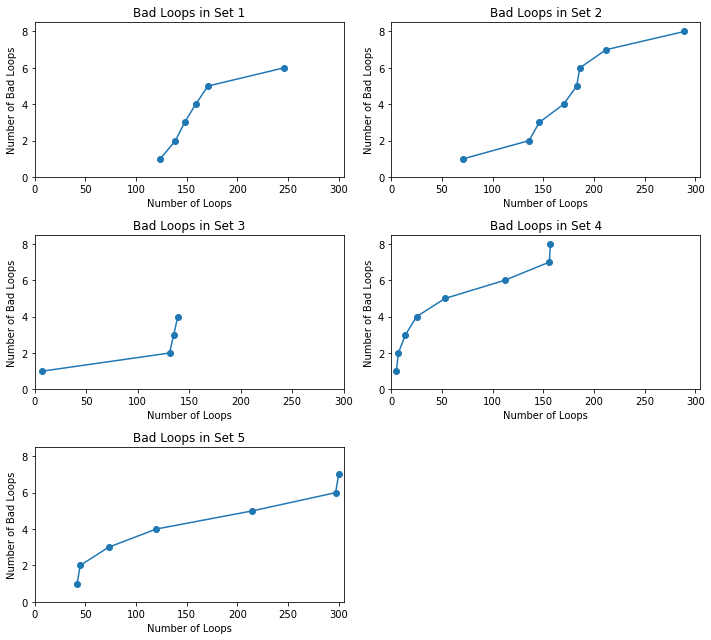

In [30]:
x1 = BLE1Loop1500_1.index
y1 = BLE1Loop1500_1['Loop']
x2 = BLE1Loop1500_2.index
y2 = BLE1Loop1500_2['Loop']
x3 = BLE1Loop1500_3.index
y3 = BLE1Loop1500_3['Loop']
x4 = BLE1Loop1500_4.index
y4 = BLE1Loop1500_4['Loop']
x5 = BLE1Loop1500_5.index
y5 = BLE1Loop1500_5['Loop']

fig0 = plt.figure(figsize=(10,9))
ax1 = fig0.add_subplot(3, 2, 1)
ax2 = fig0.add_subplot(3, 2, 2)
ax3 = fig0.add_subplot(3, 2, 3)
ax4 = fig0.add_subplot(3, 2, 4)
ax5 = fig0.add_subplot(3, 2, 5)


ax1.plot(x1, y1, linestyle='-', marker='o')
ax2.plot(x2, y2, linestyle='-', marker='o')
ax3.plot(x3, y3, linestyle='-', marker='o')
ax4.plot(x4, y4, linestyle='-', marker='o')
ax5.plot(x5, y5, linestyle='-', marker='o')


ax1.set_title('Bad Loops in Set 1')
ax1.set_ylabel('Number of Bad Loops')
ax1.set_xlabel('Number of Loops')
ax1.set_xlim(0,305)
ax1.set_ylim(0,8.5)

ax2.set_title('Bad Loops in Set 2')
ax2.set_ylabel('Number of Bad Loops')
ax2.set_xlabel('Number of Loops')
ax2.set_xlim(0,305)
ax2.set_ylim(0,8.5)

ax3.set_title('Bad Loops in Set 3')
ax3.set_ylabel('Number of Bad Loops')
ax3.set_xlabel('Number of Loops')
ax3.set_xlim(0,300)
ax3.set_ylim(0,8.5)

ax4.set_title('Bad Loops in Set 4')
ax4.set_ylabel('Number of Bad Loops')
ax4.set_xlabel('Number of Loops')
ax4.set_xlim(0,305)
ax4.set_ylim(0,8.5)

ax5.set_title('Bad Loops in Set 5')
ax5.set_ylabel('Number of Bad Loops')
ax5.set_xlabel('Number of Loops')
ax5.set_xlim(0,305)
ax5.set_ylim(0,8.5)

fig0.tight_layout()
fig0.savefig('BadLoops1500.png', bbox_inches='tight')
plt.show()


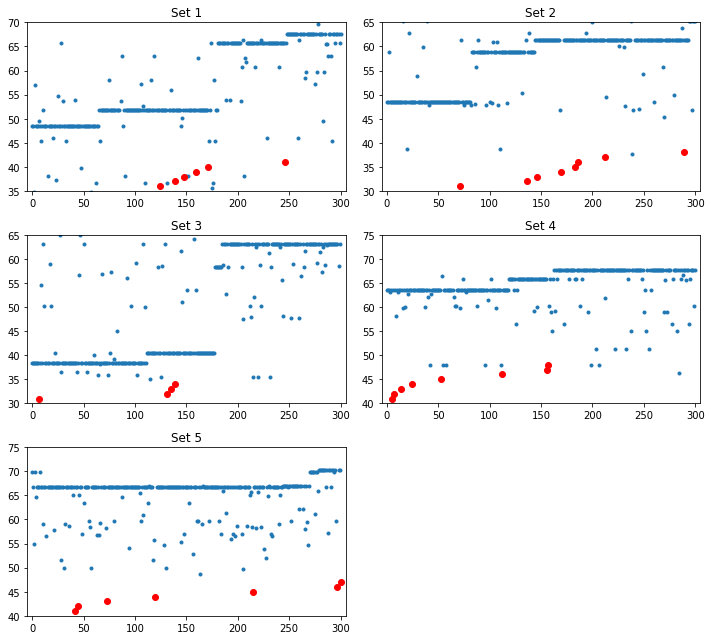

In [41]:
x1 = BLE1Loop1500_1.index
y1 = BLE1Loop1500_1['Loop'] + 35#*4 + (LE1Loop1500_1['Value'].max()-LE1Loop1500_1['Value'].min())
x2 = BLE1Loop1500_2.index
y2 = BLE1Loop1500_2['Loop'] + 30#*3 + (LE1Loop1500_2['Value'].max()-LE1Loop1500_2['Value'].min()/1.25)
x3 = BLE1Loop1500_3.index
y3 = BLE1Loop1500_3['Loop'] + 30#*4 + (LE1Loop1500_3['Value'].max()-LE1Loop1500_3['Value'].min())
x4 = BLE1Loop1500_4.index
y4 = BLE1Loop1500_4['Loop'] + 40#*3+ (LE1Loop1500_4['Value'].max()-LE1Loop1500_4['Value'].min()/1.25)
x5 = BLE1Loop1500_5.index
y5 = BLE1Loop1500_5['Loop'] + 40#*3 + (LE1Loop1500_5['Value'].max()-LE1Loop1500_5['Value'].min()/1.25)

fig0 = plt.figure(figsize=(10,9))
ax1 = fig0.add_subplot(3, 2, 1)
ax2 = fig0.add_subplot(3, 2, 2)
ax3 = fig0.add_subplot(3, 2, 3)
ax4 = fig0.add_subplot(3, 2, 4)
ax5 = fig0.add_subplot(3, 2, 5)

ax1.scatter(x=LE1Loop1500_1.index , y=LE1Loop1500_1['Value'],  marker='.')
ax1.scatter(x1, y1, linestyle='-', color='red')
ax2.scatter(x=LE1Loop1500_2.index , y=LE1Loop1500_2['Value'],  marker='.')
ax2.scatter(x2, y2, color='red')
ax3.scatter(x=LE1Loop1500_3.index , y=LE1Loop1500_3['Value'],  marker='.')
ax3.scatter(x3, y3, color='red')
ax4.scatter(x=LE1Loop1500_4.index , y=LE1Loop1500_4['Value'],  marker='.')
ax4.scatter(x4, y4, color='red')
ax5.scatter(x=LE1Loop1500_5.index , y=LE1Loop1500_5['Value'],  marker='.')
ax5.scatter(x5, y5, color='red')
ax1.set_xlim(-5, 305)
ax1.set_ylim(35, 70)
#ax1.get_yaxis().set_visible(False)
ax1.set_title('Set 1')
ax2.set_xlim(-5, 305)
ax2.set_ylim(30, 65)
#ax2.get_yaxis().set_visible(False)
ax2.set_title('Set 2')
ax3.set_xlim(-5, 305)
ax3.set_ylim(30, 65)
#ax3.get_yaxis().set_visible(False)
ax3.set_title('Set 3')
ax4.set_xlim(-5, 305)
ax4.set_ylim(40, 75)
#ax4.get_yaxis().set_visible(False)
ax4.set_title('Set 4')
ax5.set_xlim(-5, 305)
ax5.set_ylim(40, 75)
#ax5.get_yaxis().set_visible(False)
ax5.set_title('Set 5')
fig0.tight_layout()

title = 'Bad Loops with Loop History'
fig0.savefig(title, bbox_inches='tight')

plt.show()

Find Unique Loops

In [31]:
uLE1Loop1500_1 = LE1Loop1500_1.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
uLE1Loop1500_2 = LE1Loop1500_2.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
uLE1Loop1500_3 = LE1Loop1500_3.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
uLE1Loop1500_4 = LE1Loop1500_4.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
uLE1Loop1500_5 = LE1Loop1500_5.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
E1vars1500['uL'] = [len(uLE1Loop1500_1), len(uLE1Loop1500_2), len(uLE1Loop1500_3), len(uLE1Loop1500_4), len(uLE1Loop1500_5)]
E1vars1500['prL'] = (E1vars1500['L']-E1vars1500['uL'])/(E1vars1500['L']+E1vars1500['BL'])
E1vars1500['puL'] = E1vars1500['uL']/(E1vars1500['L']+E1vars1500['BL'])
E1vars1500['pBL'] = E1vars1500['BL']/(E1vars1500['L']+E1vars1500['BL'])

uvalues = pd.DataFrame(columns=['Mean Value', 'Value St.Dev.', 'Top Value', '2nd Value', '3rd Value', 'Mimimum Value'], index=np.arange(0, 5), dtype='float')
for i in uvalues.index:
    vname = 'uLE1Loop1500_' + str(i+1)
    itteration = eval(vname)
    sorted_i = itteration.sort_values('Value', ascending=False)
    uvalues.iloc[i, 0] = sorted_i['Value'].mean()
    uvalues.iloc[i, 1] = sorted_i['Value'].std()
    uvalues.iloc[i, 2] = sorted_i.iloc[0, 1]
    if len(sorted_i) > 1:
        uvalues.iloc[i, 3] = sorted_i.iloc[1, 1]
    if len(sorted_i) > 2:
        uvalues.iloc[i, 4] = sorted_i.iloc[2, 1]
    uvalues.iloc[i, 5] = sorted_i['Value'].min()

upercentile = uvalues.applymap(percentile_optimal)
uvalues.describe()

,Mean Value,Value St.Dev.,Top Value,2nd Value,3rd Value,Mimimum Value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,55.155953,8.486734,69.274853,67.628524,66.174923,36.338713
std,3.010777,1.795071,1.500332,2.038390,1.179624,2.144964
min,52.392624,6.198292,67.600929,65.358560,64.961869,33.279106
25%,53.237024,7.815535,67.665815,66.494840,64.992916,35.034254
50%,53.288168,8.113731,70.310939,66.711589,66.346296,37.115574
75%,58.412551,9.284363,70.310939,69.726904,66.973998,37.742989
max,58.449398,11.021750,70.485643,69.850729,67.599536,38.521640


In [185]:
uvalues.index = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5']
uvalues
100 - (100*E1vars1500['uL']/ E1vars1500['L'])

i=1    86.440678
i=2    88.737201
i=3    83.445946
i=4    91.126280
i=5    82.993197
dtype: float64

In [32]:
uBLE1Loop1500_1 = BLE1Loop1500_1.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
rBL_1 = BLE1Loop1500_1.shape[0] - uBLE1Loop1500_1.shape[0]

uBLE1Loop1500_2 = BLE1Loop1500_2.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
rBL_2 = BLE1Loop1500_2.shape[0] - uBLE1Loop1500_2.shape[0]

uBLE1Loop1500_3 = BLE1Loop1500_3.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
rBL_3 = BLE1Loop1500_3.shape[0] - uBLE1Loop1500_3.shape[0]

uBLE1Loop1500_4 = BLE1Loop1500_4.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
rBL_4 = BLE1Loop1500_4.shape[0] - uBLE1Loop1500_4.shape[0]

uBLE1Loop1500_5 = BLE1Loop1500_5.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
rBL_5 = BLE1Loop1500_5.shape[0] - uBLE1Loop1500_5.shape[0]

print(rBL_1, rBL_2, rBL_3, rBL_4, rBL_5)

3 4 1 3 3


Text(0, 0.5, 'Value')

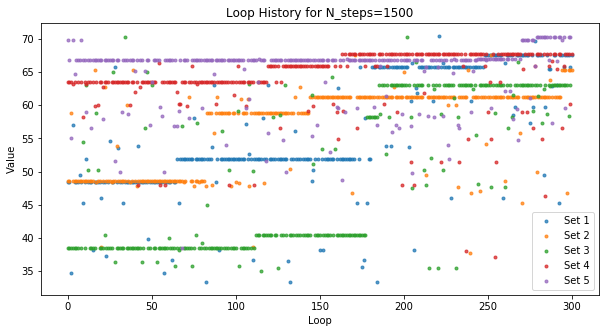

In [34]:
x1 = LE1Loop1500_1.index
y1 = LE1Loop1500_1['Value']
x2 = LE1Loop1500_2.index
y2 = LE1Loop1500_2['Value']
x3 = LE1Loop1500_3.index
y3 = LE1Loop1500_3['Value']
x4 = LE1Loop1500_4.index
y4 = LE1Loop1500_4['Value']
x5 = LE1Loop1500_5.index
y5 = LE1Loop1500_5['Value']
plt.figure(figsize=(10,5))
plt.scatter(x1, y1, alpha=.75, marker='.')
plt.scatter(x2, y2, alpha=.75, marker='.')
plt.scatter(x3, y3, alpha=.75, marker='.')
plt.scatter(x4, y4, alpha=.75, marker='.')
plt.scatter(x5, y5, alpha=.75, marker='.')
plt.legend(['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5'])
plt.title('Loop History for N_steps=1500')
plt.xlabel('Loop')
plt.ylabel('Value')

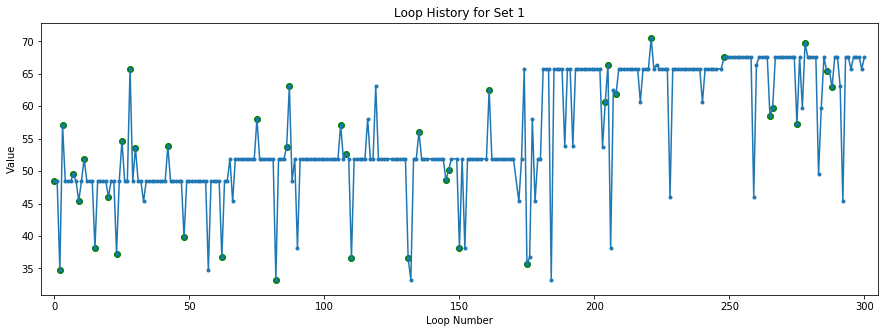

In [35]:
xL = LE1Loop1500_1.index
xuL = uLE1Loop1500_1.index
xBL = BLE1Loop1500_1.index
yL = LE1Loop1500_1['Value']
yuL = uLE1Loop1500_1['Value']
#BLind = BLE1Loop1500_1.index - 1
#yBL = LE1Loop1500_1['Value'].iloc[BLind]
yBL = BLE1Loop1500_1['Value']
x2 = BLE1Loop1500_3.index
y2 = BLE1Loop1500_3['Loop'] + 30

plt.figure(figsize=(15, 5))
#plt.plot( E1Loop1500_1.index , 'Value', data=E1Loop1500_1, linestyle='-', marker=None)
#Without BL
plt.plot( LE1Loop1500_1.index , 'Value', data=LE1Loop1500_1, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')

plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 1'
plt.title(title)
plt.xlim(-5,305)
plt.savefig(title, bbox_inches='tight')
plt.show()

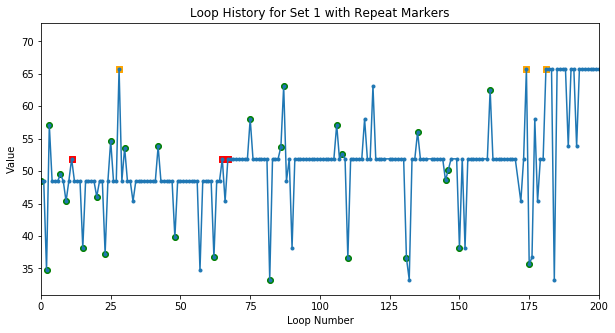

In [39]:
xL = LE1Loop1500_1.index
xuL = uLE1Loop1500_1.index
xBL = BLE1Loop1500_1.index
yL = LE1Loop1500_1['Value']
yuL = uLE1Loop1500_1['Value']
#BLind = BLE1Loop1500_1.index - 1
#yBL = LE1Loop1500_1['Value'].iloc[BLind]
yBL = BLE1Loop1500_1['Value']
x2 = BLE1Loop1500_3.index
y2 = BLE1Loop1500_3['Loop'] + 30

plt.figure(figsize=(10, 5))
#plt.plot( E1Loop1500_1.index , 'Value', data=E1Loop1500_1, linestyle='-', marker=None)
#Without BL
plt.plot( LE1Loop1500_1.index , 'Value', data=LE1Loop1500_1, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')
plt.scatter(11, LE1Loop1500_1.iloc[67,1], color='red', marker='s')
plt.scatter(65, LE1Loop1500_1.iloc[67,1], color='red', marker='s')
plt.scatter(67, LE1Loop1500_1.iloc[67,1], color='red', marker='s')
plt.scatter(28, LE1Loop1500_1.iloc[28,1], color='orange', marker='s')
plt.scatter(174, LE1Loop1500_1.iloc[28,1], color='orange', marker='s')
plt.scatter(181, LE1Loop1500_1.iloc[28,1], color='orange', marker='s')
plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 1 with Repeat Markers'
plt.title(title)
plt.xlim(0,200)
plt.savefig(title, bbox_inches='tight')
plt.show()

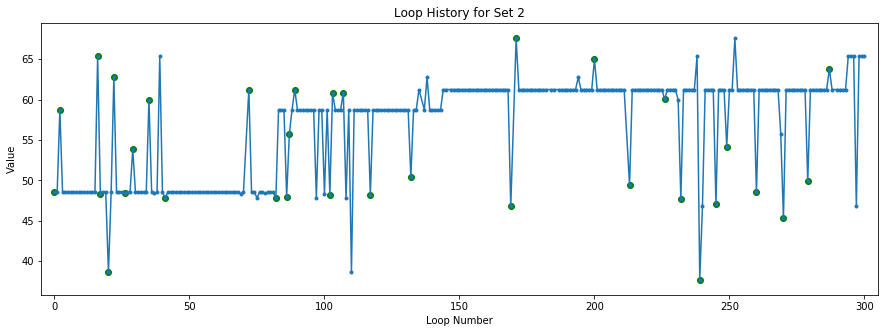

In [36]:
xuL = uLE1Loop1500_2.index
yuL = uLE1Loop1500_2['Value']
x2 = BLE1Loop1500_2.index
y2 = BLE1Loop1500_2['Loop'] + 35

plt.figure(figsize=(15, 5))

plt.plot( LE1Loop1500_2.index , 'Value', data=LE1Loop1500_2, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')
#plt.scatter(x2, y2, color='yellow')
plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 2'
plt.title(title)
plt.xlim(-5,305)
plt.savefig(title, bbox_inches='tight')
plt.show()

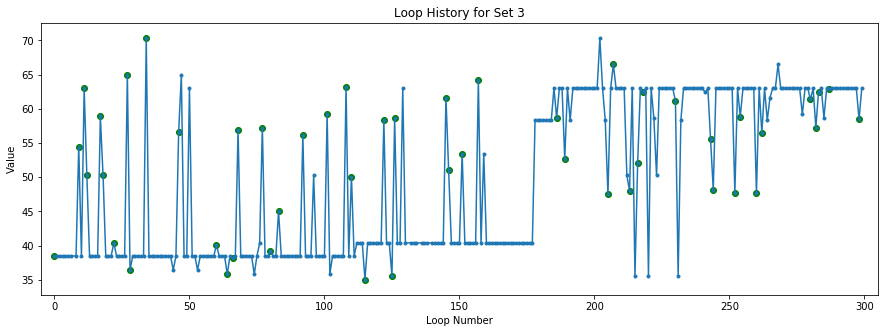

In [38]:
xuL = uLE1Loop1500_3.index
yuL = uLE1Loop1500_3['Value']
x2 = BLE1Loop1500_3.index
y2 = BLE1Loop1500_3['Loop'] + 20

plt.figure(figsize=(15, 5))

plt.plot( LE1Loop1500_3.index , 'Value', data=LE1Loop1500_3, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')
plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 3'
plt.title(title)
plt.xlim(-5,305)
plt.savefig(title, bbox_inches='tight')
plt.show()

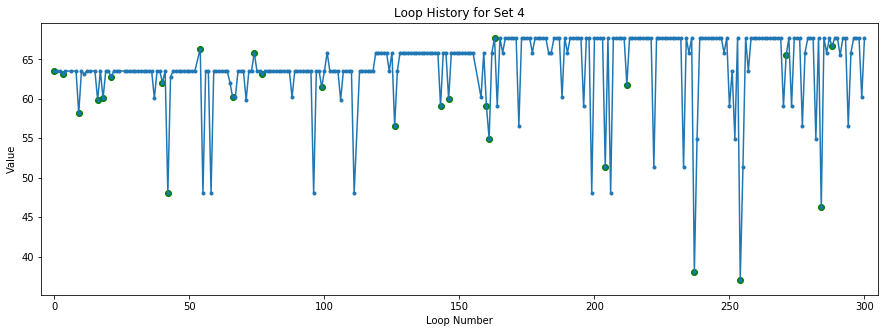

In [37]:
xuL = uLE1Loop1500_4.index
yuL = uLE1Loop1500_4['Value']
x2 = BLE1Loop1500_4.index
y2 = BLE1Loop1500_4['Loop']+35

plt.figure(figsize=(15, 5))

plt.plot( LE1Loop1500_4.index , 'Value', data=LE1Loop1500_4, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')
plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 4'
plt.title(title)
plt.xlim(-5,305)
plt.savefig(title, bbox_inches='tight')
plt.show()

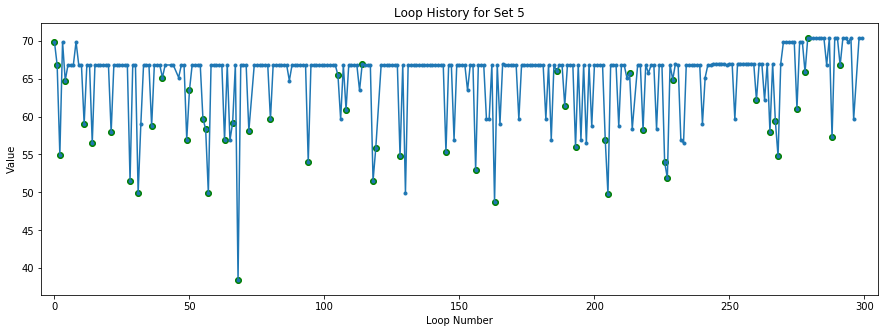

In [40]:
xuL = uLE1Loop1500_5.index
yuL = uLE1Loop1500_5['Value']
x2 = BLE1Loop1500_5.index
y2 = BLE1Loop1500_5['Loop']+35

plt.figure(figsize=(15, 5))

plt.plot( LE1Loop1500_5.index , 'Value', data=LE1Loop1500_5, linestyle='-', marker='.')
plt.scatter(xuL, yuL, color='green', marker='o')
plt.xlabel('Loop Number')
plt.ylabel('Value')
title = 'Loop History for Set 5'
plt.title(title)
plt.xlim(-5,305)
plt.savefig(title, bbox_inches='tight')
plt.show()

Breakdown by Loop

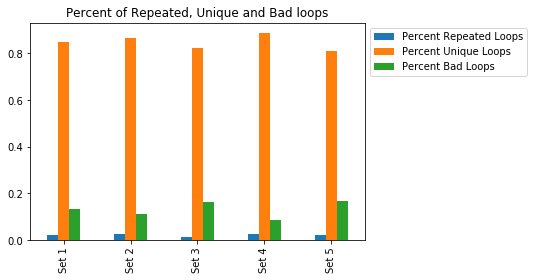

In [33]:
all_Ls = pd.DataFrame(columns=['', 'Percent Repeated Loops', 'Percent Unique Loops', 'Percent Bad Loops'])
all_Ls['Percent Repeated Loops'] = E1vars1500.iloc[:,5]
all_Ls['Percent Unique Loops'] = E1vars1500.iloc[:,3] 
all_Ls['Percent Bad Loops'] = E1vars1500.iloc[:,4]
all_Ls[''] = ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5']
all_Ls.set_index('', inplace=True)
title='Percent of Repeated, Unique and Bad loops'

all_Ls.plot(kind='bar', stacked=False, title=title).legend(bbox_to_anchor=(1.5, 1))


#### 4. N_steps=5000 Analysis 

In [42]:
E1vars5000 = pd.read_csv('E1vars5000e10g100.csv', index_col=0)
E1Loop5000_1 = pd.read_csv('E1Loop5000e10g100_1.csv', index_col=0)
BLE1Loop5000_1 = pd.DataFrame(columns=E1Loop5000_1.columns)
LE1Loop5000_1 = pd.DataFrame(columns=E1Loop5000_1.columns)
for r in range(len(E1Loop5000_1)):
    if E1Loop5000_1.iloc[r, 1] == 0:
        BLE1Loop5000_1 = BLE1Loop5000_1.append(E1Loop5000_1.loc[r])
    else:
        LE1Loop5000_1 = LE1Loop5000_1.append(E1Loop5000_1.loc[r])
uLE1Loop5000_1 = LE1Loop5000_1.drop_duplicates(subset=('Stop 1', 'Stop 2', 'Stop 3', 'Stop 4'), keep='first')
E1vars5000['uL'] = len(uLE1Loop5000_1)
E1vars5000['puL'] = E1vars5000['uL']/E1vars5000['L']

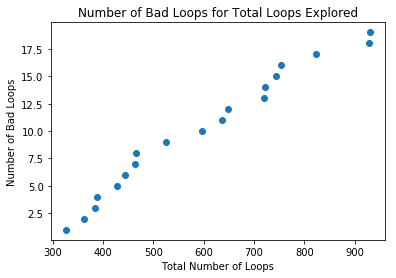

In [43]:
x = BLE1Loop5000_1.index
y = BLE1Loop5000_1['Loop']

plt.scatter(x, y)
plt.title('Number of Bad Loops for Total Loops Explored')
plt.ylabel('Number of Bad Loops')
plt.xlabel('Total Number of Loops')
plt.show()


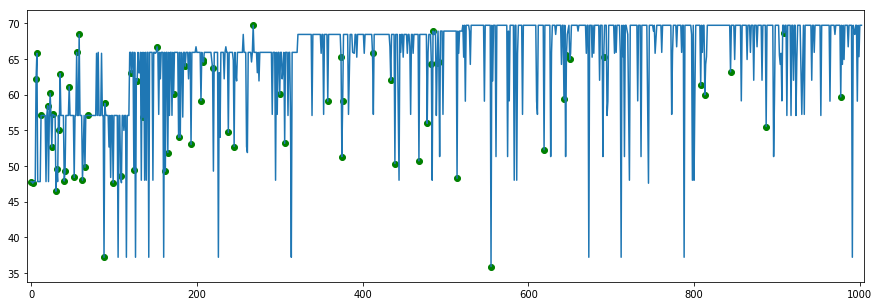

In [44]:
xuL = uLE1Loop5000_1.index
yuL = uLE1Loop5000_1['Value']
x2 = BLE1Loop5000_1.index
y2 = BLE1Loop5000_1['Loop']+35


plt.figure(figsize=(15, 5))

plt.plot( LE1Loop5000_1.index , 'Value', data=LE1Loop5000_1, linestyle='-', marker=None)
plt.scatter(xuL, yuL, color='green', marker='o')
#plt.scatter(x2, y2, color='red')

#plt.xlim(50,100)
plt.xlim(-5,1005)
plt.show()

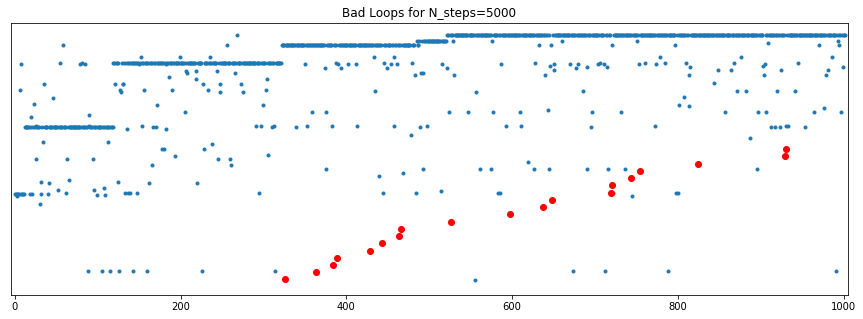

In [45]:

x2 = BLE1Loop5000_1.index
y2 = BLE1Loop5000_1['Loop']+35


plt.figure(figsize=(15, 5))

plt.scatter(LE1Loop5000_1.index , LE1Loop5000_1['Value'], marker='.')
plt.scatter(x2, y2, color='red')
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Bad Loops for N_steps=5000')
#plt.xlim(50,100)
plt.xlim(-5,1005)
plt.show()

In [38]:
OLoop['Value'].max()

72.78744617249552

In [39]:
uLE1Loop5000_1['Value'].max()

69.72690376573344

#### 5. 99th Percentile Analysis

In [46]:
vars1 = pd.read_csv('E1varsMAXe10g100.csv', index_col=0)
vars2 = pd.read_csv('E1varsMAXe10g100_2.csv', index_col=0)
vars3 = pd.read_csv('E1varsMAXe10g100_3.csv', index_col=0)
E1varsMAX = vars1.append(vars2)
E1varsMAX = E1varsMAX.append(vars3)


In [47]:
E1varsMAX['Total'] = E1varsMAX['L'] + E1varsMAX['BL']
E1varsMAX.describe()

,L,BL,Total
count,30.000000,30.000000,30.000000
mean,1051.500000,19.833333,1071.333333
std,1902.990872,42.014844,1934.830587
min,1.000000,0.000000,1.000000
25%,92.750000,2.250000,94.500000
50%,337.500000,4.500000,347.000000
75%,989.000000,15.000000,1003.250000
max,7680.000000,210.000000,7711.000000


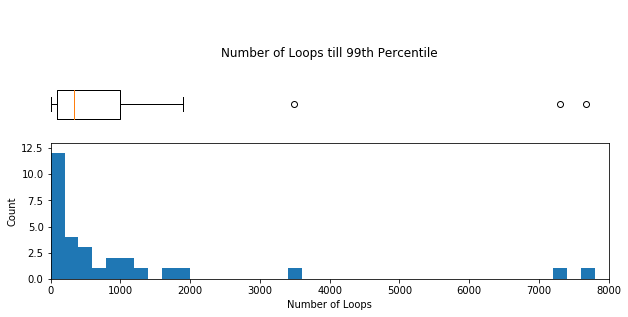

In [48]:
x = E1varsMAX['L']

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 2)
bins = np.arange(0, x.max()+200, 200)
ax1.hist(x, bins=bins)
ax1.set_xlabel('Number of Loops')
ax1.set_ylabel('Count')
ax1.set_xlim(0,8000)
ax1.set_ylim(0, 13)

ax2 = fig.add_subplot(2, 1, 1)
ax2.boxplot(x, vert=False)
title = 'Number of Loops till 99th Percentile'
ax2.set_title(title, pad=-50)
ax2.axis('off')
ax2.set_xlim(0,8000)
ax2.set_ylim(.8, 1.5)

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig(title)
#fig.tight_layout()
plt.show()

In [49]:
E1varsMAX_less = pd.DataFrame(columns=E1varsMAX.columns, dtype='float')
for r in range(len(E1varsMAX)):
    if E1varsMAX.iloc[r,0] < 3000:
        E1varsMAX_less = E1varsMAX_less.append(E1varsMAX.iloc[r])
    else:
        print('Outlier at: ', E1varsMAX.iloc[r] )
        print()
E1varsMAX_less.describe()

Outlier at:  L        3483
BL        109
Total    3592
Name: i=20, dtype: int64

Outlier at:  L        7680
BL         31
Total    7711
Name: i=24, dtype: int64

Outlier at:  L        7309
BL        210
Total    7519
Name: i=30, dtype: int64



,L,BL,Total
count,27.000000,27.000000,27.000000
mean,484.185185,9.074074,493.259259
std,530.764980,12.133634,538.144718
min,1.000000,0.000000,1.000000
25%,75.500000,2.000000,77.500000
50%,274.000000,4.000000,279.000000
75%,751.500000,10.000000,761.000000
max,1897.000000,45.000000,1906.000000


In [50]:
E1MAX_20 = pd.read_csv('E1LoopMAXe10g100_20.csv', index_col=0)
BLE1MAX_20 = pd.DataFrame(columns=E1MAX_20.columns)
LE1MAX_20 = pd.DataFrame(columns=E1MAX_20.columns)
for r in range(len(E1MAX_20)):
    if E1MAX_20.iloc[r, 1] == 0:
        BLE1MAX_20 = BLE1MAX_20.append(E1MAX_20.loc[r])
    else:
        LE1MAX_20 = LE1MAX_20.append(E1MAX_20.loc[r])

E1MAX_24 = pd.read_csv('E1LoopMAXe10g100_24.csv', index_col=0)
BLE1MAX_24 = pd.DataFrame(columns=E1MAX_24.columns)
LE1MAX_24 = pd.DataFrame(columns=E1MAX_24.columns)
for r in range(len(E1MAX_24)):
    if E1MAX_24.iloc[r, 1] == 0:
        BLE1MAX_24 = BLE1MAX_24.append(E1MAX_24.loc[r])
    else:
        LE1MAX_24 = LE1MAX_24.append(E1MAX_24.loc[r])

E1MAX_30 = pd.read_csv('E1LoopMAXe10g100_30.csv', index_col=0)
BLE1MAX_30 = pd.DataFrame(columns=E1MAX_30.columns)
LE1MAX_30 = pd.DataFrame(columns=E1MAX_30.columns)
for r in range(len(E1MAX_30)):
    if E1MAX_30.iloc[r, 1] == 0:
        BLE1MAX_30 = BLE1MAX_30.append(E1MAX_30.loc[r])
    else:
        LE1MAX_30 = LE1MAX_30.append(E1MAX_30.loc[r])
        

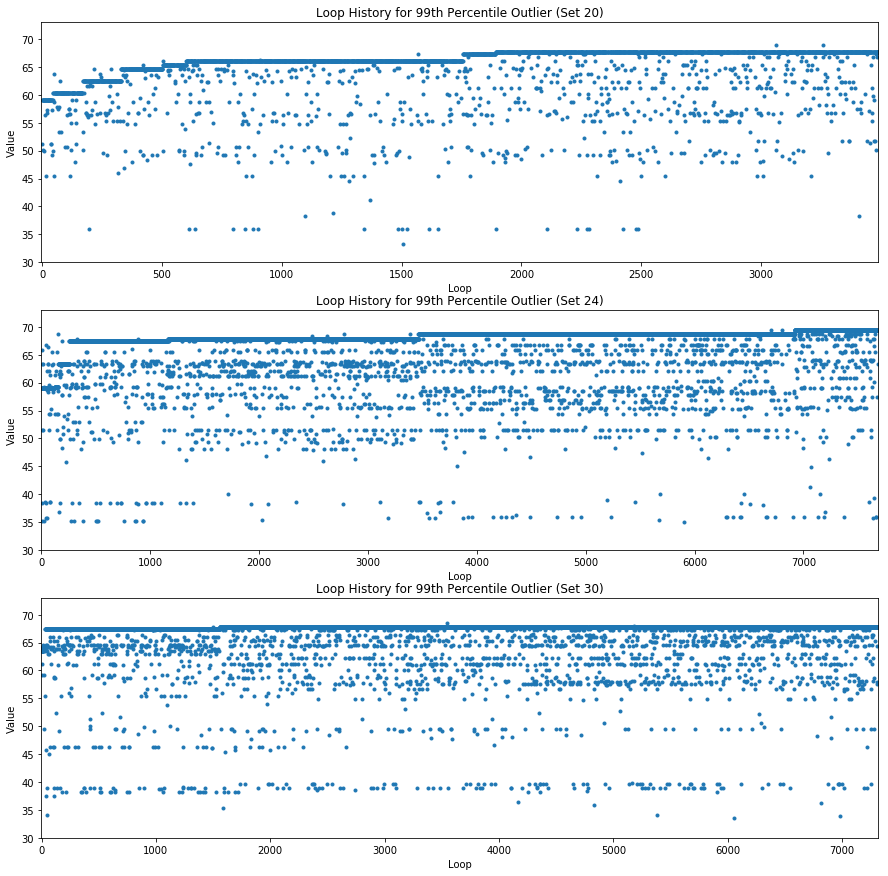

In [52]:
fig0 = plt.figure(figsize=(15, 15))
ax1 = fig0.add_subplot(3, 1, 1)
ax1.plot(LE1MAX_20.index,'Value', data=LE1MAX_20, linestyle='', marker='.')
ax2 = fig0.add_subplot(3, 1, 2)
ax2.plot(LE1MAX_24.index,'Value', data=LE1MAX_24, linestyle='', marker='.')
ax3 = fig0.add_subplot(3, 1, 3)
ax3.plot(LE1MAX_30.index,'Value', data=LE1MAX_30, linestyle='', marker='.')
ax1.set_ylim(30,73)
ax2.set_ylim(30,73)
ax3.set_ylim(30,73)
ax1.set_xlim(-5, len(LE1MAX_20['Value'])+5)
ax2.set_xlim(-5, len(LE1MAX_24['Value'])+5)
ax3.set_xlim(-5, len(LE1MAX_30['Value'])+5)

ax1.set_title('Loop History for 99th Percentile Outlier (Set 20)')
ax1.set_ylabel('Value')
ax1.set_xlabel('Loop')
ax2.set_title('Loop History for 99th Percentile Outlier (Set 24)')
ax2.set_ylabel('Value')
ax2.set_xlabel('Loop')
ax3.set_title('Loop History for 99th Percentile Outlier (Set 30)')
ax3.set_ylabel('Value')
ax3.set_xlabel('Loop')
plt.show()

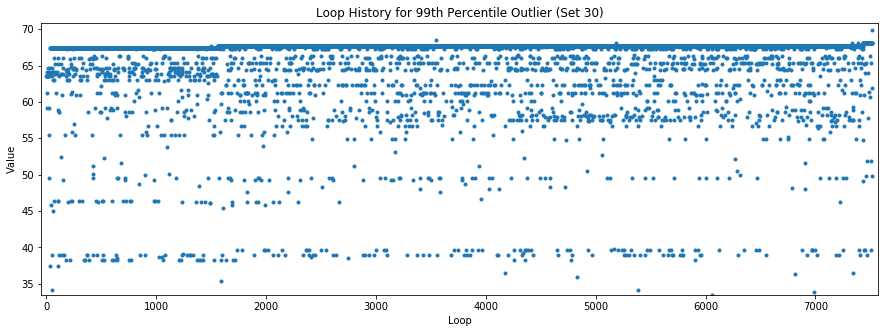

In [53]:
fig0 = plt.figure(figsize=(15, 5))
ax3 = fig0.add_subplot(1, 1, 1)
ax3.plot(LE1MAX_30.index,'Value', data=LE1MAX_30, linestyle='', marker='.')
ax3.set_ylim(LE1MAX_30['Value'].min(),LE1MAX_30['Value'].max()+1)
ax3.set_xlim(-50, len(E1MAX_30)+50)
title = 'Loop History for 99th Percentile Outlier (Set 30)'
ax3.set_title(title)
ax3.set_ylabel('Value')
ax3.set_xlabel('Loop')
fig0.savefig(title)
plt.show()

#### 6. 95th Percentile Analysis

In [168]:
E1varsMAX95 = pd.read_csv('E1varsMAX95e10g100.csv', index_col=0)
E1varsMAX95['Total'] = E1varsMAX95['L'] + E1varsMAX95['BL']
E1varsMAX95.describe()

,L,BL,Total
count,30.000000,30.000000,30.000000
mean,92.933333,2.633333,95.566667
std,138.111383,4.529469,142.348694
min,1.000000,0.000000,1.000000
25%,16.500000,0.000000,18.000000
50%,47.000000,1.000000,48.500000
75%,94.000000,3.000000,95.500000
max,668.000000,23.000000,691.000000


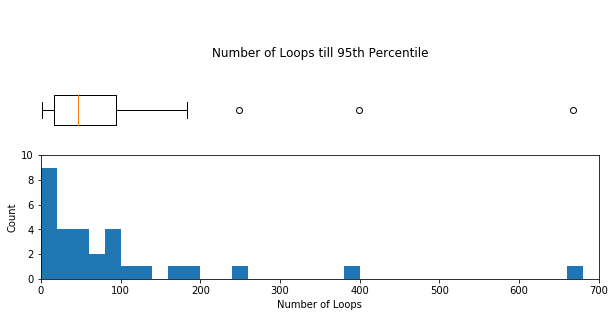

In [171]:
x = E1varsMAX95['L']

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 2)
bins = np.arange(0, x.max()+20, 20)
ax1.hist(x, bins=bins)
ax1.set_xlabel('Number of Loops')
ax1.set_ylabel('Count')
ax1.set_xlim(0,700)
ax1.set_ylim(0,10)

ax2 = fig.add_subplot(2, 1, 1)
ax2.boxplot(x, vert=False)
title = 'Number of Loops till 95th Percentile'
ax2.set_title(title, pad=-50)
ax2.axis('off')
ax2.set_xlim(0,700)
ax2.set_ylim(.9, 1.5)
fig.savefig(title)

plt.show()

In [96]:
E1varsMAX95_less = pd.DataFrame(columns=E1varsMAX95.columns, dtype='float')
for r in range(len(E1varsMAX95)):
    if E1varsMAX95.iloc[r,0] < 200:
        E1varsMAX95_less = E1varsMAX95_less.append(E1varsMAX95.iloc[r])
E1varsMAX95_less.describe()

,L,BL,Total
count,27.000000,27.000000,27.000000
mean,54.518519,1.555556,56.074074
std,49.841572,1.887883,51.123475
min,1.000000,0.000000,1.000000
25%,13.000000,0.000000,14.000000
50%,42.000000,1.000000,43.000000
75%,83.500000,3.000000,88.500000
max,183.000000,6.000000,186.000000
